# DDM MIMO

## DDM MIMO ULA

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt

from os.path import abspath, join, pardir
import sys
from numpy.fft import fft, fftshift
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from numpy import arange, cos, sin, pi, zeros

from mmWrt.Scene import Antenna, Medium, Radar, Receiver, Target, Transmitter
from mmWrt.Raytracing import rt_points
from mmWrt import __version__
print("version:", __version__)

print("last run on ", datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
version: 0.0.8-pre.1
last run on  2024-10-27 16:58:34.442277


Generic observations about the simulation
Compute: True
Radar freq: 60.0 GHz
ADC samples # 64
range resolution 0.75
Range resolution 0.75
Tc 0.0007142857142857143
T[-1] 0.038715
ts 5e-06
N adc per chirp 64
t_interchirp 0.0012
frame timing: 0.0015199999999999999
simulation time 0.0015199999999999999
Dmax 107142.85714285714
Dmax as function fs 107.14285714285714
radar lambda: 0.005
vmax :1.0416666666666667
speed resolution (within a frame of N chirps): 0.109375
---- TARGETS ---
IF frequency for target[0] is 18853.333333333332, which is 0.094 of fs
----- target[0] covers less than one range: 0.0 < 0.75 range res.
Range index: from 13.0 to 13.0
vmax of target is: 0.0 < unambiguous speed: 1.0416666666666667
vt_min: 0.0, vt_mean: 0.0, vt_max:0.0
End of simulation time: 0.038715
IF frequency for target[1] is 28186.666666666668, which is 0.14 of fs
----- target[1] covers less than one range: 0.0 < 0.75 range res.
Range index: from 20.0 to 20.0
vmax of target is: 0.0 < unambiguous speed: 1.0416

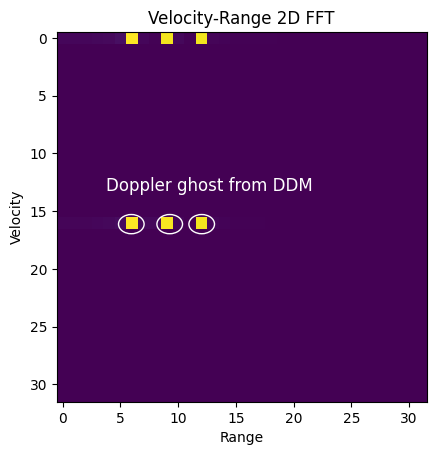

In [2]:
from scipy.fft import fft, fft2

f0 = 62e9
# Number of ADC samples
NA = 64
# Number of TX channels
NT = 2
# Number of RX channels
NR = 8
# Number of chirps (used for speed)
NC=32

tic0 = 1.2e-3

void = Medium()
c = void.v
lambda0 = c/f0
_fs = 2e5
_k = 28e10 # chirp slope
tic0 = 1.2e-3

TXs = [Antenna(x=NR*lambda0/2*i) for i in range(NT)]
RXs = [Antenna(x=lambda0/2*i) for i in range(NR)]

radar = Radar(transmitter=Transmitter(bw=0.2e9, slope=_k,
                                      antennas=TXs,
                                      t_inter_chirp=tic0,
                                      chirps_count=NC,
                                      conf={"mimo_mode":"DDM",
                                            "TX_phase_offsets":[0,0.5]}),
              receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                n_adc=NA,
                                antennas=RXs),
              debug=False)
r1, theta1 = 10.1, 0
x1, y1 = r1*cos(theta1), r1*sin(theta1)
r2, theta2 = 15.1, pi/2
x2, y2 = r2*cos(theta2), r2*sin(theta2)
r3, theta3 = 20.1, pi*0.8
x3, y3 = r3*cos(theta3), r3*sin(theta3)

target1 = Target(x1, y1, 0)  # 0 degrees on x-axis <=> -pi/2 vs bore sight
target2 = Target(x2, y2, 0) # pi/2 degrees vs x-ax <=> 0 degree vs bore sight
target3 = Target(x3, y3, 0) # 180 degrees on x-axis <=> pi/2 vs boresight
targets = [target1, target2, target3]

bb = rt_points(radar, targets,
               debug=True)
fast_time_axis = 4
slow_time_axis = 1
cube = bb["adc_cube"]
# bb[frame_i, chirp_i, tx_i, rx_i, adc_i]
virtual_cube_RX0 = bb["adc_cube"][0,:,0,0,:]
virtual_cube_RX1 = bb["adc_cube"][0,:,0,1,:]
Z = fft(fft(cube, axis=fast_time_axis), axis=slow_time_axis)
Z0 = abs(fft2(virtual_cube_RX0))
Z1 = abs(fft2(virtual_cube_RX1))

fig, (ax0) = plt.subplots(ncols=1)
ax0.set_xlabel("Range")
ax0.set_ylabel("Velocity")
ax0.set_title('Velocity-Range 2D FFT')
# ax0.imshow(Z0[:,:NA//2])
ax0.imshow(abs(Z[0,:,0, 0,:NA//2]))
sub_doppler_ghost1 = plt.Circle((0.34, 0.48), 0.02, fill=False, color="white")
sub_doppler_ghost2 = plt.Circle((0.4, 0.48), 0.02, fill=False, color="white")
sub_doppler_ghost3 = plt.Circle((0.45, 0.48), 0.02, fill=False, color="white")
fig.text(0.3, 0.55, f"Doppler ghost from DDM", color="white", fontsize=12)
fig.add_artist(sub_doppler_ghost1)
fig.add_artist(sub_doppler_ghost2)
fig.add_artist(sub_doppler_ghost3)
# ax1.imshow(Z1[:,:NA//2])

(16, 16, 32)


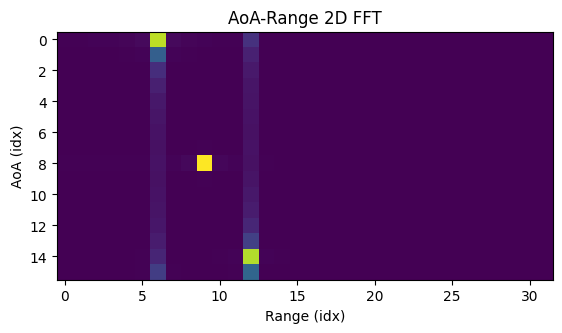

In [6]:
from scipy.signal import find_peaks
# generate virtual antennas

# important to declare the zeros as complex otherwise assignement
# forces a type cast to real
virtual_cube = zeros(( NC//NT, NT * NR, NA//2)).astype(complex)
print(virtual_cube.shape)
for tx_idx in range(NT):
    for rx_idx in range(NR):
        # virtual antenna index =
        # tx_idx*NT+ rx_idx
        virtual_rx_idx = tx_idx*NR+ rx_idx
        virtual_cube[:,virtual_rx_idx,:] = Z[0, tx_idx*NC//NT:(tx_idx+1)*NC//NT, 0, rx_idx, :NA//2]

doppler_axis=0
rx_axis = 1
range_axis=2
A = fftshift(fft(virtual_cube, axis=rx_axis), axes=1)
# plot AoA at zero Doppler
plt.xlabel("Range (idx)")
plt.ylabel("AoA (idx)")
plt.title('AoA-Range 2D FFT')
plt.imshow(abs(A[0,:,:]))

## Dummy sub doppler

range peaks (array([ 6,  9, 12, 52, 55, 58], dtype=int64), {})
first range bin 6
doppler peaks (array([16, 26], dtype=int64), {})
sub doppler width 10
min 16
15.0


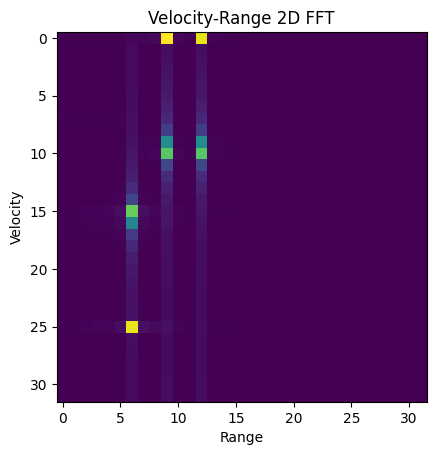

In [12]:
from numpy import mean, concatenate, array
radar = Radar(transmitter=Transmitter(bw=0.2e9, slope=_k,
                                      antennas=TXs,
                                      t_inter_chirp=tic0,
                                      chirps_count=NC,
                                      conf={"mimo_mode":"DDM",
                                            "TX_phase_offsets":[0,0.3]}),
              receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                n_adc=NA,
                                antennas=RXs),
              debug=False)
r1, theta1 = 10.1, 0
x1, y1 = r1*cos(theta1), r1*sin(theta1)
r2, theta2 = 15.1, pi/2
x2, y2 = r2*cos(theta2), r2*sin(theta2)
r3, theta3 = 20.1, pi*0.8
x3, y3 = r3*cos(theta3), r3*sin(theta3)

v1 = 1.0
target1 = Target(x1, y1, 0, xt= lambda t: x1+v1*t)  # 0 degrees on x-axis <=> -pi/2 vs bore sight
target2 = Target(x2, y2, 0) # pi/2 degrees vs x-ax <=> 0 degree vs bore sight
target3 = Target(x3, y3, 0) # 180 degrees on x-axis <=> pi/2 vs boresight
targets = [target1, target2, target3]

bb = rt_points(radar, targets,
               debug=False)
fast_time_axis = 4
slow_time_axis = 1
cube = bb["adc_cube"]
# bb[frame_i, chirp_i, tx_i, rx_i, adc_i]
virtual_cube_RX0 = bb["adc_cube"][0,:,0,0,:]
virtual_cube_RX1 = bb["adc_cube"][0,:,0,1,:]
Z = fft(fft(cube, axis=fast_time_axis), axis=slow_time_axis)
Z0 = abs(fft2(virtual_cube_RX0))
Z1 = abs(fft2(virtual_cube_RX1))

fig, (ax0) = plt.subplots(ncols=1)
ax0.set_xlabel("Range")
ax0.set_ylabel("Velocity")
ax0.set_title('Velocity-Range 2D FFT')
ax0.imshow(abs(Z[0,:,0, 0,:NA//2]))

# find peaks
range_pks = find_peaks(abs(Z[0,0,0,0,:]))
print("range peaks", range_pks)
range_bin_idx = range_pks[0][0]
print("first range bin",range_bin_idx)
doppler_peaks = find_peaks(concatenate((array([0]),abs(Z[0,:,0,0,range_bin_idx]))))
print("doppler peaks", doppler_peaks)
doppler_peaks = doppler_peaks[0]
sub_dop_width = NC//(NT+1)
print("sub doppler width", sub_dop_width)
print("min", min(doppler_peaks))
if min(doppler_peaks) >= sub_dop_width:
    dopplers = [d-(idx+1)*sub_dop_width-1 for idx,d in enumerate(doppler_peaks)]
    # print("dopplers shifted", dopplers)
    print(sub_dop_width+mean(dopplers))

In [11]:
# non regression hook
# ensure first range bin does not have velocity 
# < NF//NT
assert min(doppler_peaks) == 16
assert min(doppler_peaks) >= NC//NT